In [276]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import lightgbm as lbg
from tqdm import tqdm
import polars as pl
import json
from abc import ABC, abstractmethod

from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
import seaborn as sns

In [277]:
class Config():

    ROOT = os.path.join("predict-energy-behavior-of-prosumers")
    

    # country id mapping
    COUNTRY_ID_TO_NAME_MAP_DIR = os.path.join(ROOT,"county_id_to_name_map.json")
    with open(COUNTRY_ID_TO_NAME_MAP_DIR,'r') as country_id_to_name:
        COUNTRY_ID_TO_NAME = json.load(country_id_to_name)

    # loading the weather station to country mapping 
    WEATHER_STATION_TO_COUNTRY_MAPPING_DIR = os.path.join(ROOT,"weather_station_to_county_mapping.csv")
    WEATHER_STATION_TO_COUNTRY_MAPPING = pd.read_csv(WEATHER_STATION_TO_COUNTRY_MAPPING_DIR)
    # Preprocess the Weather station mapping as the unknown mapping is 12 and give the name unknown
    WEATHER_STATION_TO_COUNTRY_MAPPING.fillna({"county_name":"UNKNOWN","county":12},inplace = True)
    WEATHER_STATION_TO_COUNTRY_MAPPING = pl.from_pandas(WEATHER_STATION_TO_COUNTRY_MAPPING)
    

    
    # paths of all the files for the training 
    TRAIN_CLIENT = os.path.join(ROOT,"client.csv")
    TRAIN_ELECTRICITY_PRICES = os.path.join(ROOT,"electricity_prices.csv")
    TRAIN_FORCAST_WEATHER = os.path.join(ROOT,"forecast_weather.csv")
    TRAIN_GAS_PRICES = os.path.join(ROOT,"gas_prices.csv")
    TRAIN_HISTORICAL_WEATHER = os.path.join(ROOT,"historical_weather.csv")
    TRAIN_TRAIN = os.path.join(ROOT, "train.csv")
    TRAIN_WEATHER_STATION_TO_COUNTRY_MAPPING = os.path.join(ROOT,"weather_station_to_country_mapping.csv")

    # paths of all the files for the testing
    TEST_CLIENT = os.path.join(ROOT,"example_test_files","client.csv")
    TEST_ELECTRICITY_PRICES = os.path.join(ROOT,"example_test_files","electricity_prices.csv")
    TEST_FORCAST_WEATHER = os.path.join(ROOT,"example_test_files","forecast_weather.csv")
    TEST_GAS_PRICES = os.path.join(ROOT,"example_test_files","gas_prices.csv")
    TEST_HISTORICAL_WEATHER = os.path.join(ROOT,"example_test_files","historical_weather.csv")
    TEST_TEST = os.path.join(ROOT,"example_test_files", "test.csv")
    TEST_WEATHER_STATION_TO_COUNTRY_MAPPING = os.path.join(ROOT,"example_test_files","weather_station_to_country_mapping.csv")



In [278]:
# DataStorage class will be injected into the feature engineering class 
# This will create a lot of memory instead create the data storage class and add wrapers arround it 
# just like adding decorators to the class so as to     

In [279]:
class DataStorage:

    def __init__(self):
        # loading all the training data 
        self.train_df_data = pl.read_csv(Config.TRAIN_TRAIN,try_parse_dates = True)
        self.train_df_client = pl.read_csv(Config.TRAIN_CLIENT,try_parse_dates = True)
        self.train_df_electricity_prices = pl.read_csv(Config.TRAIN_ELECTRICITY_PRICES,try_parse_dates = True)
        self.train_df_forcast_weather = pl.read_csv(Config.TRAIN_FORCAST_WEATHER,try_parse_dates = True)
        self.train_df_gas_prices = pl.read_csv(Config.TRAIN_GAS_PRICES,try_parse_dates = True)
        self.train_df_historical_weather = pl.read_csv(Config.TRAIN_HISTORICAL_WEATHER,try_parse_dates = True)

        # loading all the testing data 
        self.test_df_data = pl.read_csv(Config.TEST_TEST,try_parse_dates = True)
        self.test_df_client = pl.read_csv(Config.TEST_CLIENT,try_parse_dates = True)
        self.test_df_electricity_prices = pl.read_csv(Config.TEST_ELECTRICITY_PRICES,try_parse_dates = True)
        self.test_df_forcast_weather = pl.read_csv(Config.TEST_FORCAST_WEATHER,try_parse_dates = True)
        self.test_df_gas_prices = pl.read_csv(Config.TEST_GAS_PRICES,try_parse_dates = True)
        self.test_df_historical_weather = pl.read_csv(Config.TEST_HISTORICAL_WEATHER,try_parse_dates = True)
        

In [280]:
# the base class which is used in the decorator design pattern
class AddFeatures(ABC):
    
    @abstractmethod
    def addFeature(self,df):
        # Here add some of the feature to the df and pass the df along 
        if df is None:
            raise ValueError("This features should not be first to be added")
        pass
        

    def addOneLagFeature(self,df,group_by_column,col_name,new_col_name,lag):
        df = df.group_by(group_by_column).map_groups(lambda group: group.with_columns(
                                                    pl.col(col_name).shift(lag).alias(new_col_name)))
        return df

    

    def addLagFeatures(self,df,columns: list,hour_lag_start: int, hour_lag_finish : int ,day_lag_start : int ,day_lag_finish : int):

        # Add both day and hour lag features 
        for column in tqdm(columns,desc = f"Working on {self.__class__.__name__}"):
            
            for hour_lag in range(hour_lag_start,hour_lag_finish):
                # Adding hour lag features 
                df = self.addOneLagFeature(df,"datetime",column,f"{column}_lag_by_hour_{hour_lag}",hour_lag)
                
            for day_lag in range(day_lag_start,day_lag_finish):
                # Adding day lag features
                df = self.addOneLagFeature(df,"date",column,f"{column}_lag_by_day_{day_lag}",day_lag)
        
        return df
        

    def cleanUp(self):
        pass

In [281]:
# add general features 
class AddGeneralFeatures(AddFeatures):

    def __init__(self,df):
        self.df = df
        

    def addFeature(self,df = None):
        # Adding basic features such as hours,day, weekday etc
        self.df = self.df.with_columns(
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.date().alias("date")
        )

        # Adding new features 
        # the freaquncy is set to 0.5 to the max value 
        self.df = self.df.with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )

        # drop data_block_id 
        self.df = self.df.drop(["data_block_id"])

        # print(f"After the {self.__class__.__name__} {self.df.shape}")
        
        
        if df is None: 
            return self.df
        # perform the join operation
        
        raise ValueError("First features should be General Features")
          

In [282]:
class AddClientFeatures(AddFeatures):

    def __init__(self,df):
        self.df = df

    def addFeature(self,df = None):
        # just combine the dataframe based on the country , is_business, date and product type 
        # perform left join 
        super().addFeature(df)

        #drop data_block_id
        self.df = self.df.drop(["data_block_id"])
        
        df = df.join(
            self.df,
            on = ["county","is_business","date","product_type"],
            how = "left",
        )

        # print(f"After the {self.__class__.__name__} {df.shape}")        
        return df

In [283]:
class AddElectricityPricesFeatures(AddFeatures):

    def __init__(self,df):
        self.df = df

        
    def addFeature(self,df = None):
        # just combine the dataframe based on the 
        super().addFeature(df)

        # Rename the forcast_datetime to datetime 
        self.df = self.df.rename({"forecast_date":"datetime"})

        # Drop the origin date and data_block_id 
        self.df = self.df.drop(["data_block_id","origin_date"])
        

        # TODO: Right now not adding this features
        df = df.join(
            self.df,
            on = ["datetime"],
            how = "left",
        )
        # print(f"After the {self.__class__.__name__} {df.shape}")
 
        # try hourLag,monthLag and dayLag all of this 6-8 values 

        # Add hourLag,DayLag features 
        df = self.addLagFeatures(df,["euros_per_mwh"],hour_lag_start=1,hour_lag_finish=8,day_lag_start=1,day_lag_finish=3)  

        return df

In [284]:
class AddForecastWeatherFeatures(AddFeatures):

    def __init__(self,df):
        self.df = df

    def addFeature(self,df = None):
        # just combine the dataframe based on the 
        super().addFeature(df)
        # adding the country column
        self.df = self.df.join(
            Config.WEATHER_STATION_TO_COUNTRY_MAPPING,
            on = ["latitude","longitude"],
            how = "left",
        )

        # Droping the latitude and longitude columns 
        self.df = self.df.drop(["latitude","longitude","data_block_id","county_name","origin_datetime"])

        # Change the name of the forecast_datetime to datetime
        self.df = self.df.rename({"forecast_datetime":"datetime"})

        # Perform aggreagation 
        # TODO: right now taking the mean of according to the datetime and the country 
        # TODO: try different different techniques such as expontential smotthing and the houter winters 

        self.df = self.df.group_by(["county","datetime"]).mean()

        # convert the cast of country to int64
        self.df = self.df.with_columns(
            pl.col("county").cast(pl.Int64).alias("county"),
        )
    
        # Perform join based on the datetime,country and data_block_id with the original dataset    
        df = df.join(
            self.df,
            on = ["county","datetime"],
            how = "left",
        )

        # Adding extra lag features
        lag_features = ["temperature","dewpoint","cloudcover_high","cloudcover_low","cloudcover_mid","cloudcover_total","10_metre_u_wind_component",
 "10_metre_v_wind_component","direct_solar_radiation","surface_solar_radiation_downwards","total_precipitation","snowfall"]
        df = self.addLagFeatures(df,lag_features,hour_lag_start=1,hour_lag_finish=8,day_lag_start=1,day_lag_finish=3)  
    
        
        # print(f"After the {self.__class__.__name__} {df.shape}")
    
        return df

In [285]:
class AddHistoricalWeatherFeatures(AddFeatures):

    def __init__(self,df):
        self.df = df

    def addFeature(self,df = None):
        # just combine the dataframe based on the 
        super().addFeature(df)
        # adding the country column
        self.df = self.df.join(
            Config.WEATHER_STATION_TO_COUNTRY_MAPPING,
            on = ["latitude","longitude"],
            how = "left",
        )

        # Droping the latitude,longitude and data_block_id columns 
        self.df = self.df.drop(["latitude","longitude","data_block_id","county_name"])

        self.df = self.df.with_columns(
            pl.col("county").cast(pl.Int64).alias("county"),
        )

        self.df = self.df.group_by(["county","datetime"]).mean()
    
        # Perform join based on the datetime,country and data_block_id with the original dataset    
        df = df.join(
            self.df,
            on = ["county","datetime"],
            how = "left",
            suffix = f"_historical"
        )

        # Adding extra lag features
        lag_features = ["temperature","dewpoint","rain","snowfall","surface_pressure","cloudcover_total","cloudcover_low",
                         "cloudcover_mid","cloudcover_high","windspeed_10m","winddirection_10m","shortwave_radiation","direct_solar_radiation"]
        df = self.addLagFeatures(df,lag_features,hour_lag_start=1,hour_lag_finish=8,day_lag_start=1,day_lag_finish=3)  

        

        # print(f"After the {self.__class__.__name__} {df.shape}")
        return df

In [286]:
class AddGasPricesFeatures(AddFeatures):

    def __init__(self,df):
        self.df = df

    def addFeature(self,df = None):
        # just combine the dataframe based on the 
        super().addFeature(df)

        # TODO: Right now not adding this feature

         # Rename the forcast_datetime to datetime 
        self.df = self.df.rename({"forecast_date":"date"})

        # Drop the origin date and data_block_id 
        self.df = self.df.drop(["data_block_id","origin_date"])

        df = df.join(
            self.df,
            on = ["date"],
            how = "left",
        )

        # Add hourLag,DayLag features
        lag_features = ["lowest_price_per_mwh","highest_price_per_mwh"]
        df = self.addLagFeatures(df,lag_features,hour_lag_start=1,hour_lag_finish=8,day_lag_start=1,day_lag_finish=3)  


        
        # print(f"After the {self.__class__.__name__} {df.shape}")

        return df

In [291]:
class AddFeatureManager():

    def __init__(self,dataStorage : DataStorage,thresholdDate= "2023-03-01 23:00:00",validation = True):
        self.addGeneralFeatures = AddGeneralFeatures(dataStorage.train_df_data)
        self.addClientFeatures = AddClientFeatures(dataStorage.train_df_client)
        self.addElectricityPricesFeatures = AddElectricityPricesFeatures(dataStorage.train_df_electricity_prices)
        self.addForcastWeatherFeatures = AddForecastWeatherFeatures(dataStorage.train_df_forcast_weather)
        self.addHistoricalWeatherFeatures = AddHistoricalWeatherFeatures(dataStorage.train_df_historical_weather)
        self.addGasPricesFeatures = AddGasPricesFeatures(dataStorage.train_df_gas_prices)
        self.threshold_date = thresholdDate
        self.validation = validation 
        self.df = None

    def safeDrop(self,column,df):
        if column in df.columns:
            df = df.drop(columns = [column])
        return df
            
    def to_pandas(self):
        # Convert to pandas
        
        categorical_cols = ["county","is_business","product_type","is_consumption"]
        df = self.df.to_pandas()
        df = df.set_index("row_id")
        df[categorical_cols] = df[categorical_cols].astype("category")

        if self.validation:
            val_df = df[df["datetime"] > self.threshold_date]
            df = df[df["datetime"]<= self.threshold_date]
            df = self.safeDrop("datetime",df)
            df = self.safeDrop("date",df)
            val_df = self.safeDrop("datetime",val_df)
            val_df = self.safeDrop("date",val_df)
            return df,val_df

        # drop date and datetime column 
        df = self.safeDrop("datetime",df)
        df = self.safeDrop("date",df)
        
        return df,None

    def addFeatures(self):
        self.allOperations = [self.addGeneralFeatures,self.addClientFeatures,
                             self.addElectricityPricesFeatures,self.addForcastWeatherFeatures,
                             self.addHistoricalWeatherFeatures,self.addGasPricesFeatures]
        for operation in self.allOperations:
            self.df = operation.addFeature(self.df)
        return self.to_pandas()

In [292]:
data_storage = DataStorage()

In [293]:
add_feature_manager = AddFeatureManager(data_storage)

In [ ]:
train_df,val_df = add_feature_manager.addFeatures()    # for general case
# train_df = add_feature_manager.addFeatures()        # ony activate this when in debugging phase

Working on AddForecastWeatherFeatures:  25%|█▎   | 3/12 [01:18<03:58, 26.50s/it]

## Model

In [55]:
class Model:

    def __init__(self,optuna = False,):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 16,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": "cpu",
            "verbosity": 1
        }
        self.model = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i,),
                )
                for i in range(10)
            ]
        )

    def fit(self,df):
        self.model.fit(
            X = df.drop(columns = ["target"]),
            y = df["target"]
        )

    def predict(self,df):
        predictions = np.zeros(len(df))
        predict = self.model.predict(df)
        return predict
        


In [56]:
# Split the model into training and validation dataset 
train_df.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'prediction_unit_id', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'eic_count', 'installed_capacity', 'hours_ahead',
       'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'temperature_historical', 'dewpoint_historical', 'rain',
       'snowfall_historical', 'surface_pressure',
       'cloudcover_total_historical', 'cloudcover_low_historical',
       'cloudcover_mid_historical', 'cloudcover_high_historical',
       'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
       'direct_solar_radiation_historical', 'diffuse_radiation'],
      dtype='object')

In [57]:
model = Model()
model.fit(train_df)

[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7352
[LightGBM] [Info] Number of data points in the train set: 1729824, number of used 

In [58]:
# Perform corss validation to check the model performance
def ComputeMAE(model,val_df):
    if val_df is None: 
        return 0
    prediction = model.predict(val_df.drop(columns = ["target"]))
    y_true = val_df["target"]
    score = np.mean(np.abs(y_true-prediction))
    return score

In [59]:
score = ComputeMAE(model,val_df)
print(f"The score obtained is : {score}")

[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=3.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [W

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


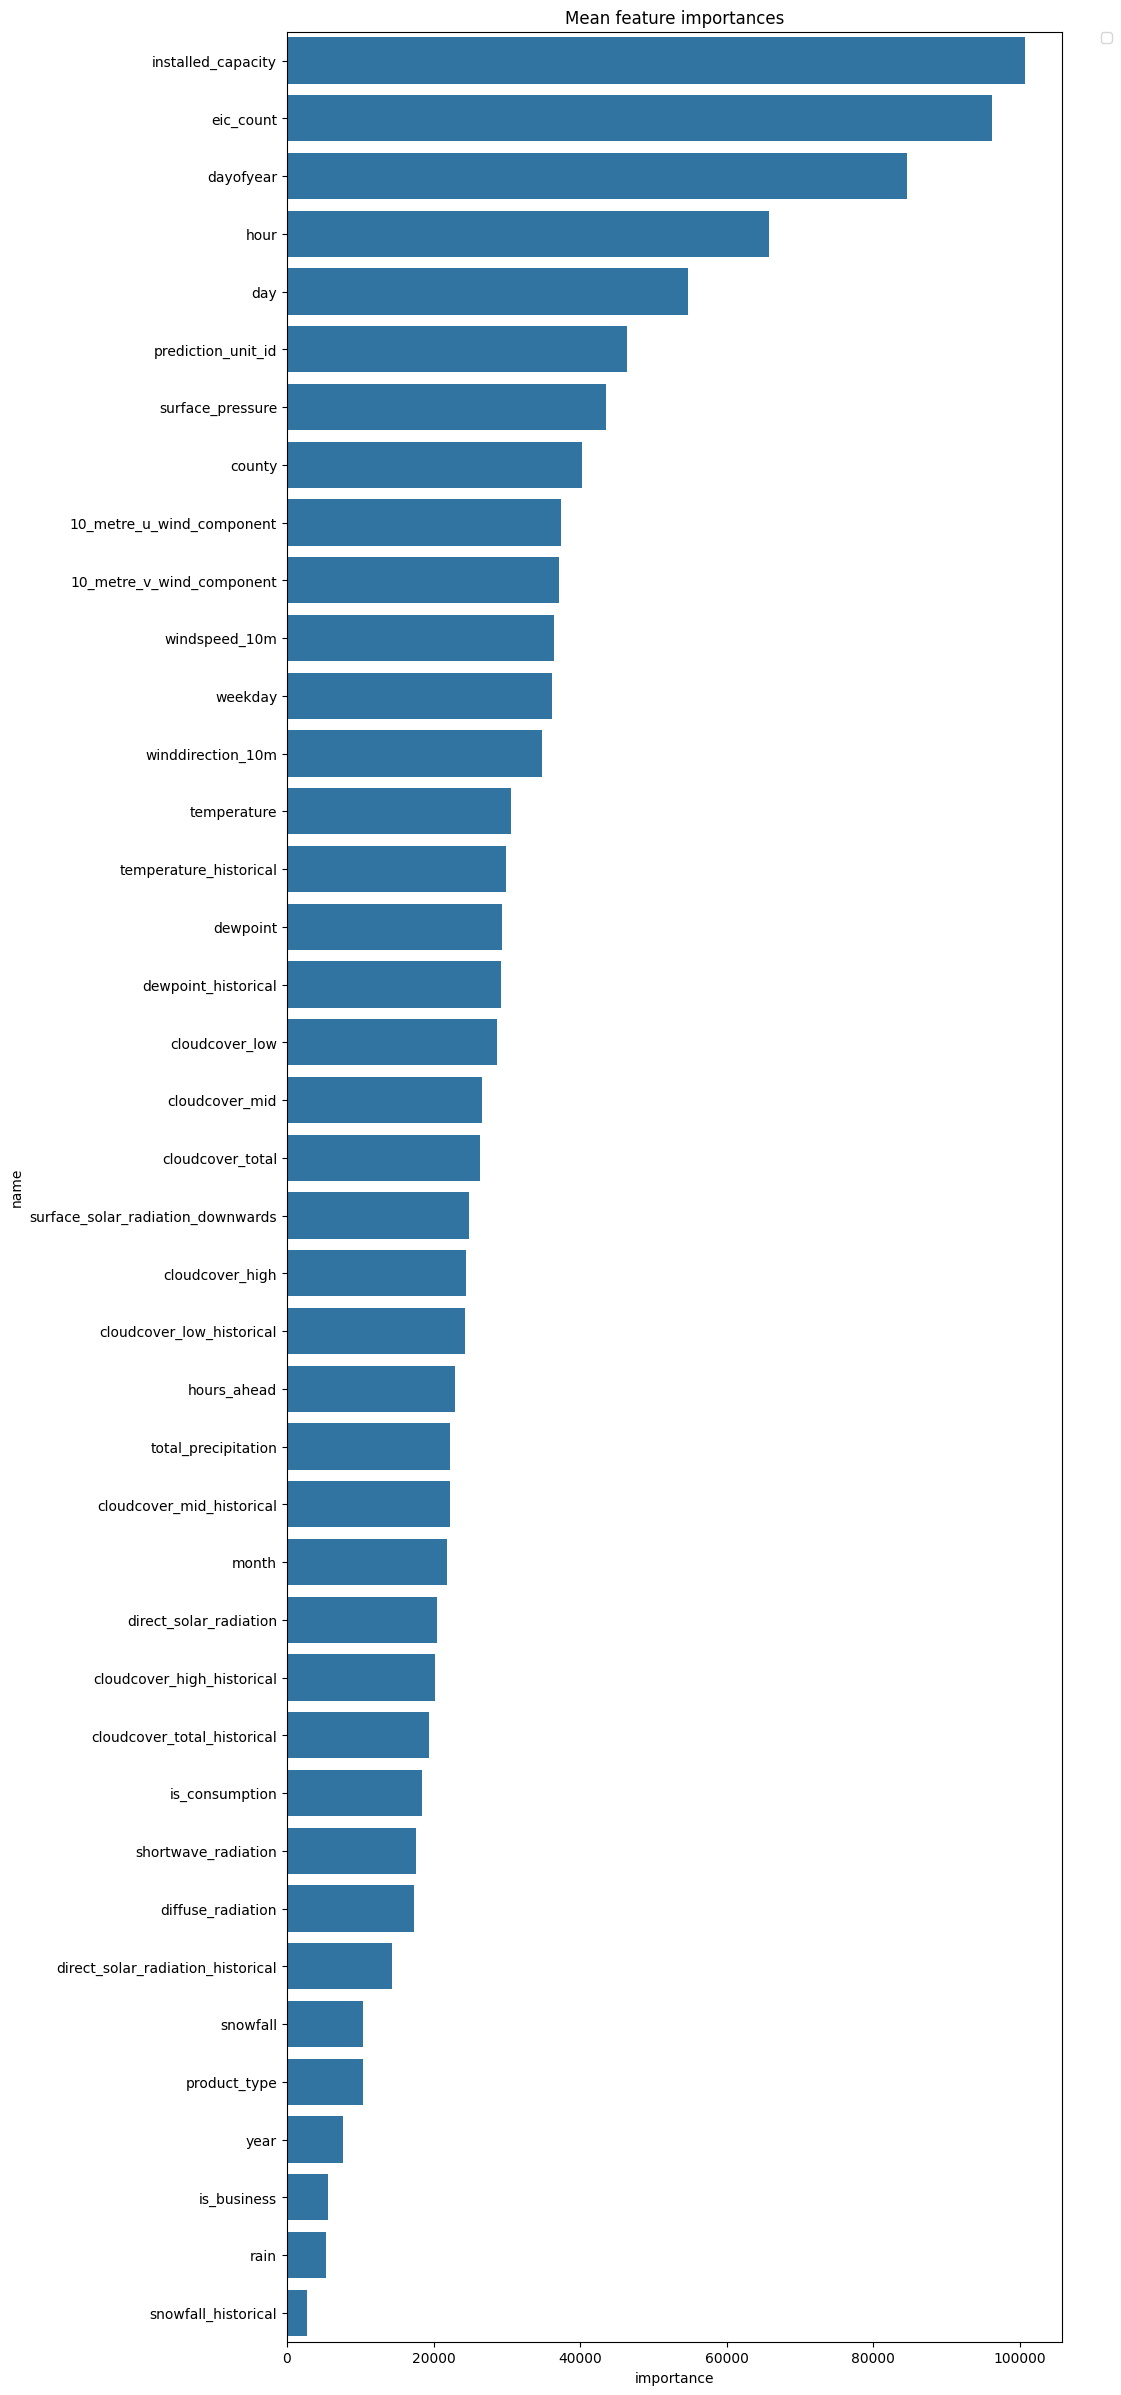

In [82]:
def plotFeatureImportance(model
feature_importances_values = np.asarray([model.feature_importances_ for model in model.model.estimators_]).mean(axis=0)
feature_importance_df = pd.DataFrame({'name': [ i for i in list(train_df.columns) if  i != "target"], 'importance': feature_importances_values})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 30))
ax = sns.barplot(data=feature_importance_df, x='importance', y='name', dodge=False)
ax.set_title(f"Mean feature importances")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [74]:
len(feature_importances_values)

40

(1729824, 41)

## Submissions

In [27]:
# import enefit

# env = enefit.make_env()
# iter_test = env.iter_test()

## Exploratory Data Analysis

In [24]:
temp = data_storage.train_df_data

In [25]:
temp.head()

county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
i64,i64,i64,f64,i64,datetime[μs],i64,i64,i64
0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
0,0,1,96.59,1,2021-09-01 00:00:00,0,1,0
0,0,2,0.0,0,2021-09-01 00:00:00,0,2,1
0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [26]:
temp.with_columns(
    pl.col("datetime").dt.hour().alias("hour"),
    pl.col("datetime").dt.day().alias("day"),
    pl.col("datetime").dt.weekday().alias("weekday"),
    pl.col("datetime").dt.month().alias("month"),
    pl.col("datetime").dt.year().alias("year"),
    pl.col("datetime").dt.ordinal_day().alias("dayofyear")
)

county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,day,weekday,month,year,dayofyear
i64,i64,i64,f64,i64,datetime[μs],i64,i64,i64,i8,i8,i8,i8,i32,i16
0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,0,1,3,9,2021,244
0,0,1,96.59,1,2021-09-01 00:00:00,0,1,0,0,1,3,9,2021,244
0,0,2,0.0,0,2021-09-01 00:00:00,0,2,1,0,1,3,9,2021,244
0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,0,1,3,9,2021,244
0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,0,1,3,9,2021,244
0,0,3,656.859,1,2021-09-01 00:00:00,0,5,2,0,1,3,9,2021,244
0,1,0,0.0,0,2021-09-01 00:00:00,0,6,3,0,1,3,9,2021,244
0,1,0,59.0,1,2021-09-01 00:00:00,0,7,3,0,1,3,9,2021,244
0,1,1,0.0,0,2021-09-01 00:00:00,0,8,4,0,1,3,9,2021,244
